<a href="https://colab.research.google.com/github/gbachu/causal-inference-pipeline/blob/main/causal_inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time
*   2/25: 8:30 pm - 10: pm - 11:30 pm
----
*   3/4: 10:30 pm - 11 pm,
*   3/5: 8 pm - 12 am


# Causal structure discovery: Pipeline

In [ ]:
# colab setup
!git clone https://github.com/eberharf/fges-py.git  # Editing: https://github.com/gbachu/fges-py.git
!pip install -q corner dill sortedcontainers gdown
!cd fges-py
import gdown
gdown.download_folder(url='https://drive.google.com/drive/folders/1ODVzVVEl6gIzXcyS3ytC4AR2dN3YzbQ4?usp=drive_link',
                      output='new_data', quiet=True)

Cloning into 'fges-py'...
remote: Enumerating objects: 532, done.
remote: Total 532 (delta 0), reused 0 (delta 0), pack-reused 532
Receiving objects: 100% (532/532), 10.25 MiB | 6.77 MiB/s, done.
Resolving deltas: 100% (340/340), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.2 MB/s eta 0:00:00


['new_data/labels.txt', 'new_data/tetrad_galacticus_table_acyclic.dat']

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')
import sys
sys.path.append('fges-py')
from SEMScore import *
from fges import *

## Load data

In [ ]:
# Loads Astrophysics Data with Labels for Advanced Testing
def load_data():
    data_path = '/content/new_data/tetrad_galacticus_table_acyclic.dat'
    data = np.loadtxt(data_path, delimiter=' ', skiprows=1)
    return data

def load_labels():
    label_path = '/content/new_data/labels.txt'
    label_file = open(label_path, "r")
    labels = (label_file.read()).split()
    return labels

# Generates Simple Y-Structure Data for Quick Testing / Expected Output References
def generate_data(n_samples=5000, noise_scale=1):
    # generate samples
    A = np.random.normal(0, 1, (n_samples,))
    B = np.random.normal(0, 1, (n_samples,))
    C = 3*A + 2*B + np.random.normal(0, noise_scale, (n_samples,))
    D = 0.5*C + np.random.normal(0, noise_scale, (n_samples,))

    data = np.stack([A, B, C, D], axis=1)

    #zscore
    data = (data - data.mean(axis=0)) / data.std(axis=0)

    var_names = ['A', 'B', 'C', 'D']
    return data, var_names

# Load Data using one of generate_data (Y-Structure) or load_data + load_labels (Astrophysics Data)
data = load_data()
var_names = load_labels()

## Initial data exploration

To make sure the data matches our expectations, we:
1. Print out the shape of the data and the names of the variables included
2. Construct a [corner plot](https://corner.readthedocs.io/en/latest/pages/quickstart/)
3. Plot the correlation matrix
4. Plot the precision matrix

In [ ]:
print(data.shape)
print(var_names)

(1460, 7)
['basicMass', 'diskMassStellar', 'spheroidMassStellar', 'diskMassGas', 'spheroidMassGas', 'hotHaloMass', 'blackHoleMass']


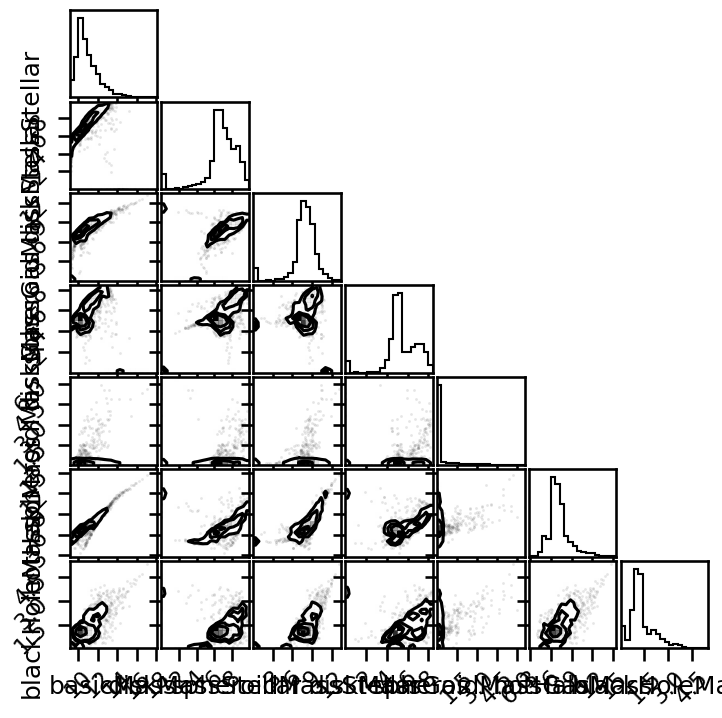

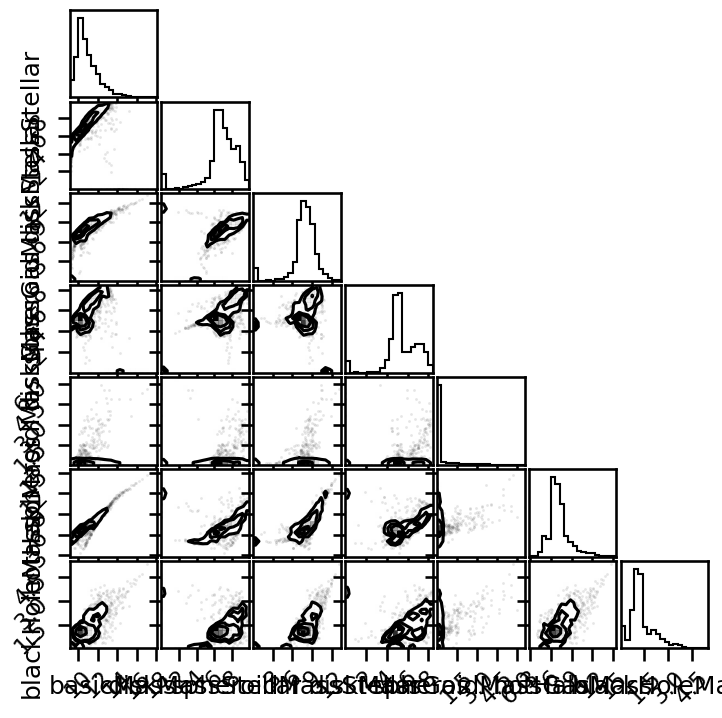

In [ ]:
from corner import corner

# Astrophysics Data
# fig = plt.figure(figsize=(25,25))
# corner(data[:,:7], labels=var_names, fig=fig); #WARNING:root:Too few points to create valid contours

# For Y-Structure Data
fig = plt.figure(figsize=(7,7))
corner(data, labels=var_names, fig=fig)

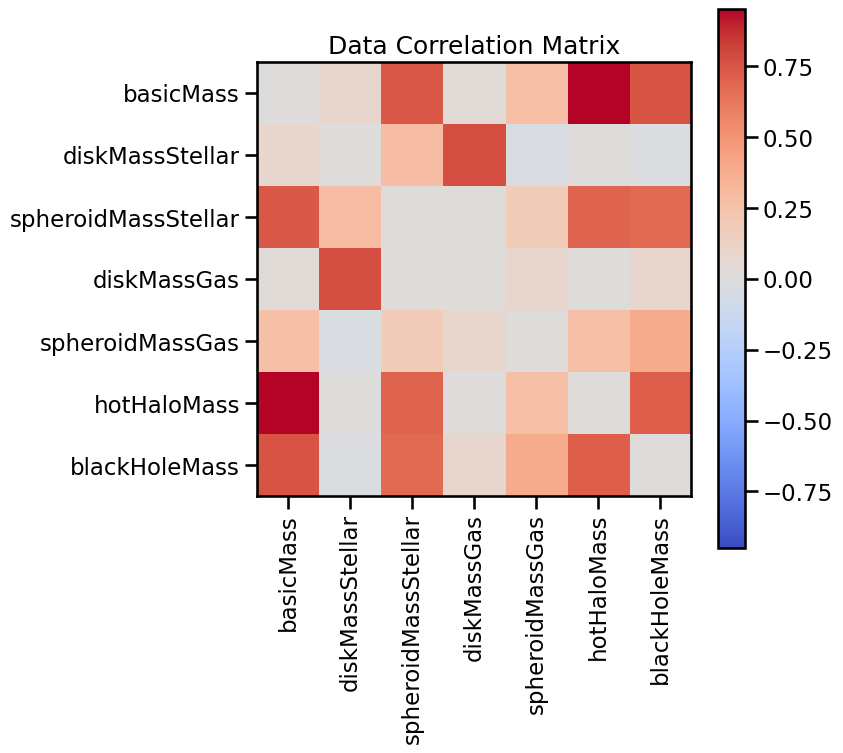

In [ ]:
# Plots the correlation matrix (zeroing out the diagonal)
corr = np.corrcoef(data.T)
np.fill_diagonal(corr, 0)

fig,ax = plt.subplots(figsize=(7,7))
vbound = np.nanmax(np.abs(corr))
im = ax.imshow(corr, cmap='coolwarm', vmin=-vbound, vmax=vbound)

ax.set_xticks(np.arange(len(var_names)))
ax.set_yticks(np.arange(len(var_names)))
ax.set_xticklabels(var_names, rotation=90, ha='center')
ax.set_yticklabels(var_names)
ax.set_title('Data Correlation Matrix')
plt.colorbar(im, ax=ax);

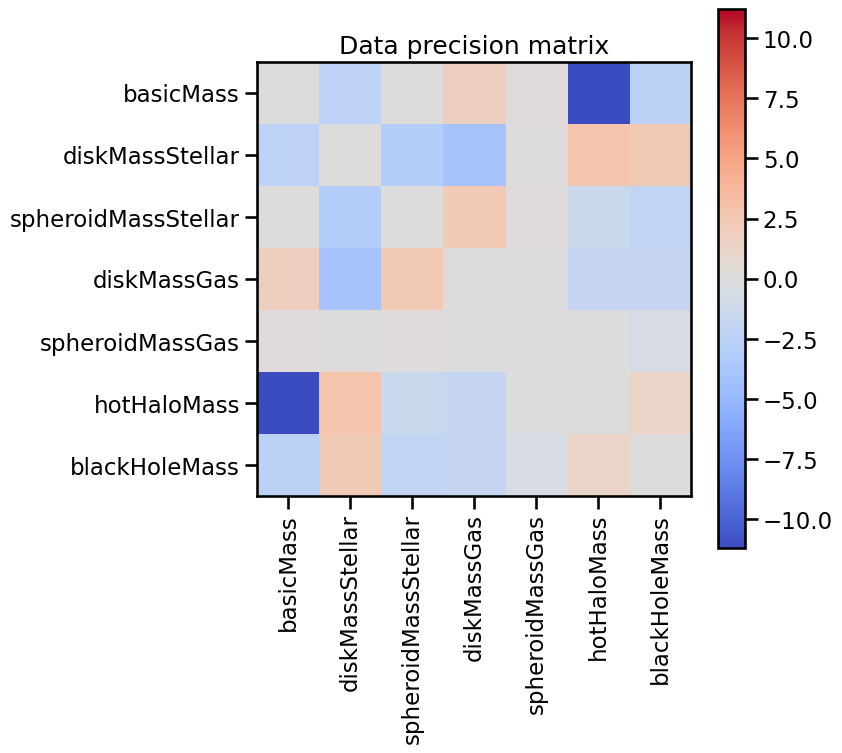

In [ ]:
# Plots the precision matrix between the variables.
# Setting the diagonal terms to 0 so we can focus
# on the relationships between variables.

corr = np.corrcoef(data.T)
prec = np.linalg.inv(corr)
np.fill_diagonal(prec, 0)

fig,ax = plt.subplots(figsize=(7,7))
vbound = np.nanmax(np.abs(prec))
im = ax.imshow(prec, cmap='coolwarm', vmin=-vbound, vmax=vbound)

ax.set_xticks(np.arange(len(var_names)))
ax.set_yticks(np.arange(len(var_names)))
ax.set_xticklabels(var_names, rotation=90)
ax.set_yticklabels(var_names)
ax.set_title('Data precision matrix')
plt.colorbar(im, ax=ax);

## Run the FGES algorithm

For working with a relatively large dataset, we can use an
alternative to the PC algorithm called Fast Greedy Equivalence Search (FGES),
which is optimized for large numbers of variables.
The implementation we will use can be found [here](https://github.com/eberharf/fges-py),
and details about the algorithm can be found in Ramsey et al. 2016.

The following function specifies an FGES object that infers edges across our
variables from the data provided.

In [ ]:
def infer_edges(data, s=8): #TODO: Test various sparsity numbers
    '''
    Arguments:
        data : an n_samples x n_nodes array
        s : sparsity parameter for FGES (default = 8 as was used in Dubois et al.)
    Returns:
        edges : a list of tuples, where each tuple (i,j) represents an edge
                found between node i and node j
        fges_result : dict of results from fges.search() (needed for estimating
                      the correlation matrix later on)
    '''

    # FGES takes a score function that depends on the data and a user-determined
    # sparsity level (penalty discount)
    score = SEMBicScore(penalty_discount=s, dataset=data) #bic = bayesian information criterion

    # run FGES
    fges = FGES(range(data.shape[1]), score, filename=data)
    fges_result = fges.search()
    edges = fges_result['graph'].edges()
    return edges, fges_result

edges,fges_result = infer_edges(data)

This package specifies adjacencies in the PDAG as a list of tuples (`edges`), where each tuple $(i,j)$ included in the list indicates a directed edge from $i$ into $j$. An undirected edge is represented by including both $(i,j)$ and $(j,i)$ in the list.

Function `fges_edges_to_mat` takes as input:

- `edges` : a list of edge tuples
- `n_nodes` : the total number of variables in our graph

Return an `n_nodes` x `n_nodes` numpy array, where entries
$(i,j)$ and $(j,i)$ are both set to 1 if there is an edge between node $i$ and
node $j$ and are 0 otherwise.

We use this function to convert the `edges` list constructed above to an array
`adj_mat` and visualize the resulting array.

In [ ]:
# convert list of edges that fges returns to an adjacency matrix where entries
# (i,j) and (j,i) are 1 if there is an edge between node i and node j and 0 otherwise
def fges_edges_to_mat(edges, n_nodes):
    adj_mat = np.zeros((n_nodes,n_nodes))
    for edge in edges:
        adj_mat[edge[0], edge[1]] = 1
        adj_mat[edge[1], edge[0]] = 1 #TODO: edit for directed graph?
    return adj_mat

adj_mat = fges_edges_to_mat(edges, data.shape[1])

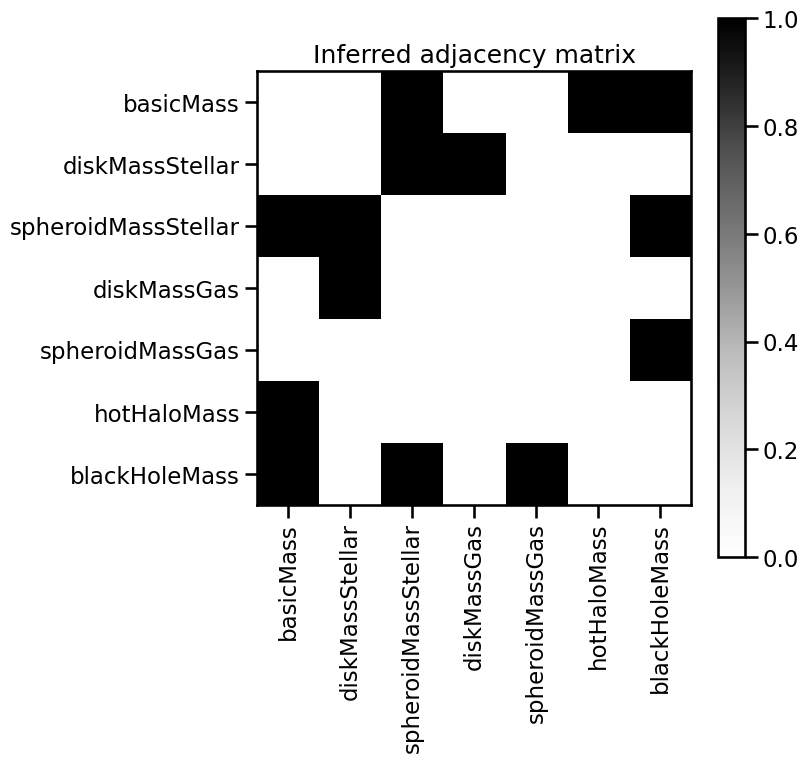

In [ ]:
# visualize adjacency matrix found by algorithm. What structure do you see?
fig,ax = plt.subplots(figsize=(7,7))
im = ax.imshow(adj_mat, cmap='Greys', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(var_names)))
ax.set_yticks(np.arange(len(var_names)))
ax.set_xticklabels(var_names, rotation=90, ha='center')
ax.set_yticklabels(var_names)
ax.set_title('Inferred adjacency matrix')
plt.colorbar(im, ax=ax);

In other workflows, we had to 1) convert the PDAG to a DAG,
2) estimate the weights connection weights and residuals, and 3) compute
the resulting correlation matrix of the estimated graph. However, `fges-py` provides a class called `SemEstimator` that will do this all for us. The following function
does so and returns the numpy array `est_corr` that is the correlation matrix
from the inferred graph.

In [ ]:
from SemEstimator import SemEstimator

def estimate_corr(data, fges_result):
    '''
    Arguments:
        data : an n_samples x n_nodes numpy array
        fges_result : a dict of results returned by fges.search()
    Returns:
        est_corr : an n_nodes x n_nodes numpy array estimated correlation matrix
    '''
    sem_est = SemEstimator(data, sparsity=4)

    # provide to the estimator the DAG found above
    sem_est.pattern = fges_result['graph']

    # estimate the weights and residuals
    sem_est.estimate()

    # get covariance matrix from SemEstimator
    est_cov = sem_est.graph_cov

    # compute correlation matrix from covariance matrix
    stdistdj = np.sqrt(np.diag(est_cov))
    est_corr = est_cov / np.outer(stdistdj, stdistdj)
    return est_corr

est_corr = estimate_corr(data, fges_result)

/content/fges-py/search_util.py:172: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params, r, _, _ = np.linalg.lstsq(a, b)


Visualizing the estimated correlation matrix (zeroing out the diagonal). Compare it to the correlation matrix computed from the data.

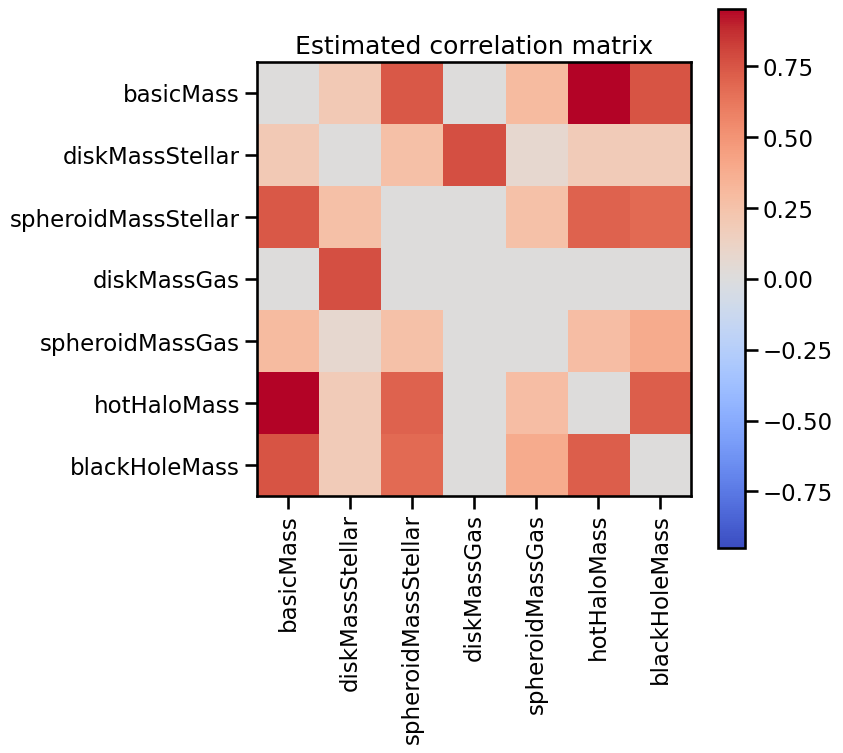

In [ ]:
# zero out diagonal
np.fill_diagonal(est_corr, 0)

# plot correlation matrix
fig,ax = plt.subplots(figsize=(7,7))
vbound = np.nanmax(np.abs(est_corr))
im = ax.imshow(est_corr, cmap='coolwarm', vmin=-vbound, vmax=vbound)
ax.set_xticks(np.arange(len(var_names)))
ax.set_yticks(np.arange(len(var_names)))
ax.set_xticklabels(var_names, rotation=90, ha='center')
ax.set_yticklabels(var_names)
ax.set_title('Estimated correlation matrix')
plt.colorbar(im, ax=ax);

To quantify how closely the estimated correlation matrix matches that found
from the data, we vectorize the lower-triangular elements in the true
and estimated matrices and compute the Pearson correlation between the two vectors.

In [ ]:
true_vec = corr[np.tril_indices(corr.shape[0],-1)].flatten()
est_vec = est_corr[np.tril_indices(est_corr.shape[0],-1)].flatten()
print(np.corrcoef(true_vec, est_vec)[0,1])

0.9758032382375552


## Compare graphs found from different subject groups

Now that we have performed this analysis in the most straightforward way, we can compare the results of this pipeline across variations of the data (varying batches and sparsity) to compare results across the data, noting if any part is over or under represented in our initial analysis.

So, for each subset / sample of our set, we will:

1. load in the data
2. run FGES to get a list of inferred edges
3. convert the list of edges to an adjacency matrix
4. store the adjacency matrix found on each loop iteration in a list.

In [ ]:
all_data = data # NOTE: make sure to change for Y-Structure data
batches = np.array_split(data, 3)

sparsity_adj_mats = []
batch_adj_mats = []
default_sparsity = 8

# Seperately batching and varying sparsity
for sparsity in range(1,21):
      # set data to all
      data = all_data

      # run FGES
      edges,fges_result = infer_edges(data, s=sparsity)

      # convert edges to adj_mat
      adj_mat = fges_edges_to_mat(edges, data.shape[1])
      sparsity_adj_mats.append(adj_mat)

for batch in batches:
    # set data to batch
    data = batch

    # run FGES
    edges,fges_result = infer_edges(data, s=default_sparsity)

    # convert edges to adj_mat
    adj_mat = fges_edges_to_mat(edges, data.shape[1])
    batch_adj_mats.append(adj_mat)

adj_mats = sparsity_adj_mats + batch_adj_mats

Next, we will compute the average adjacency matrix and visualize it with `plt.imshow` to see how often each edge is found from data across sample sets with varying sparcities.

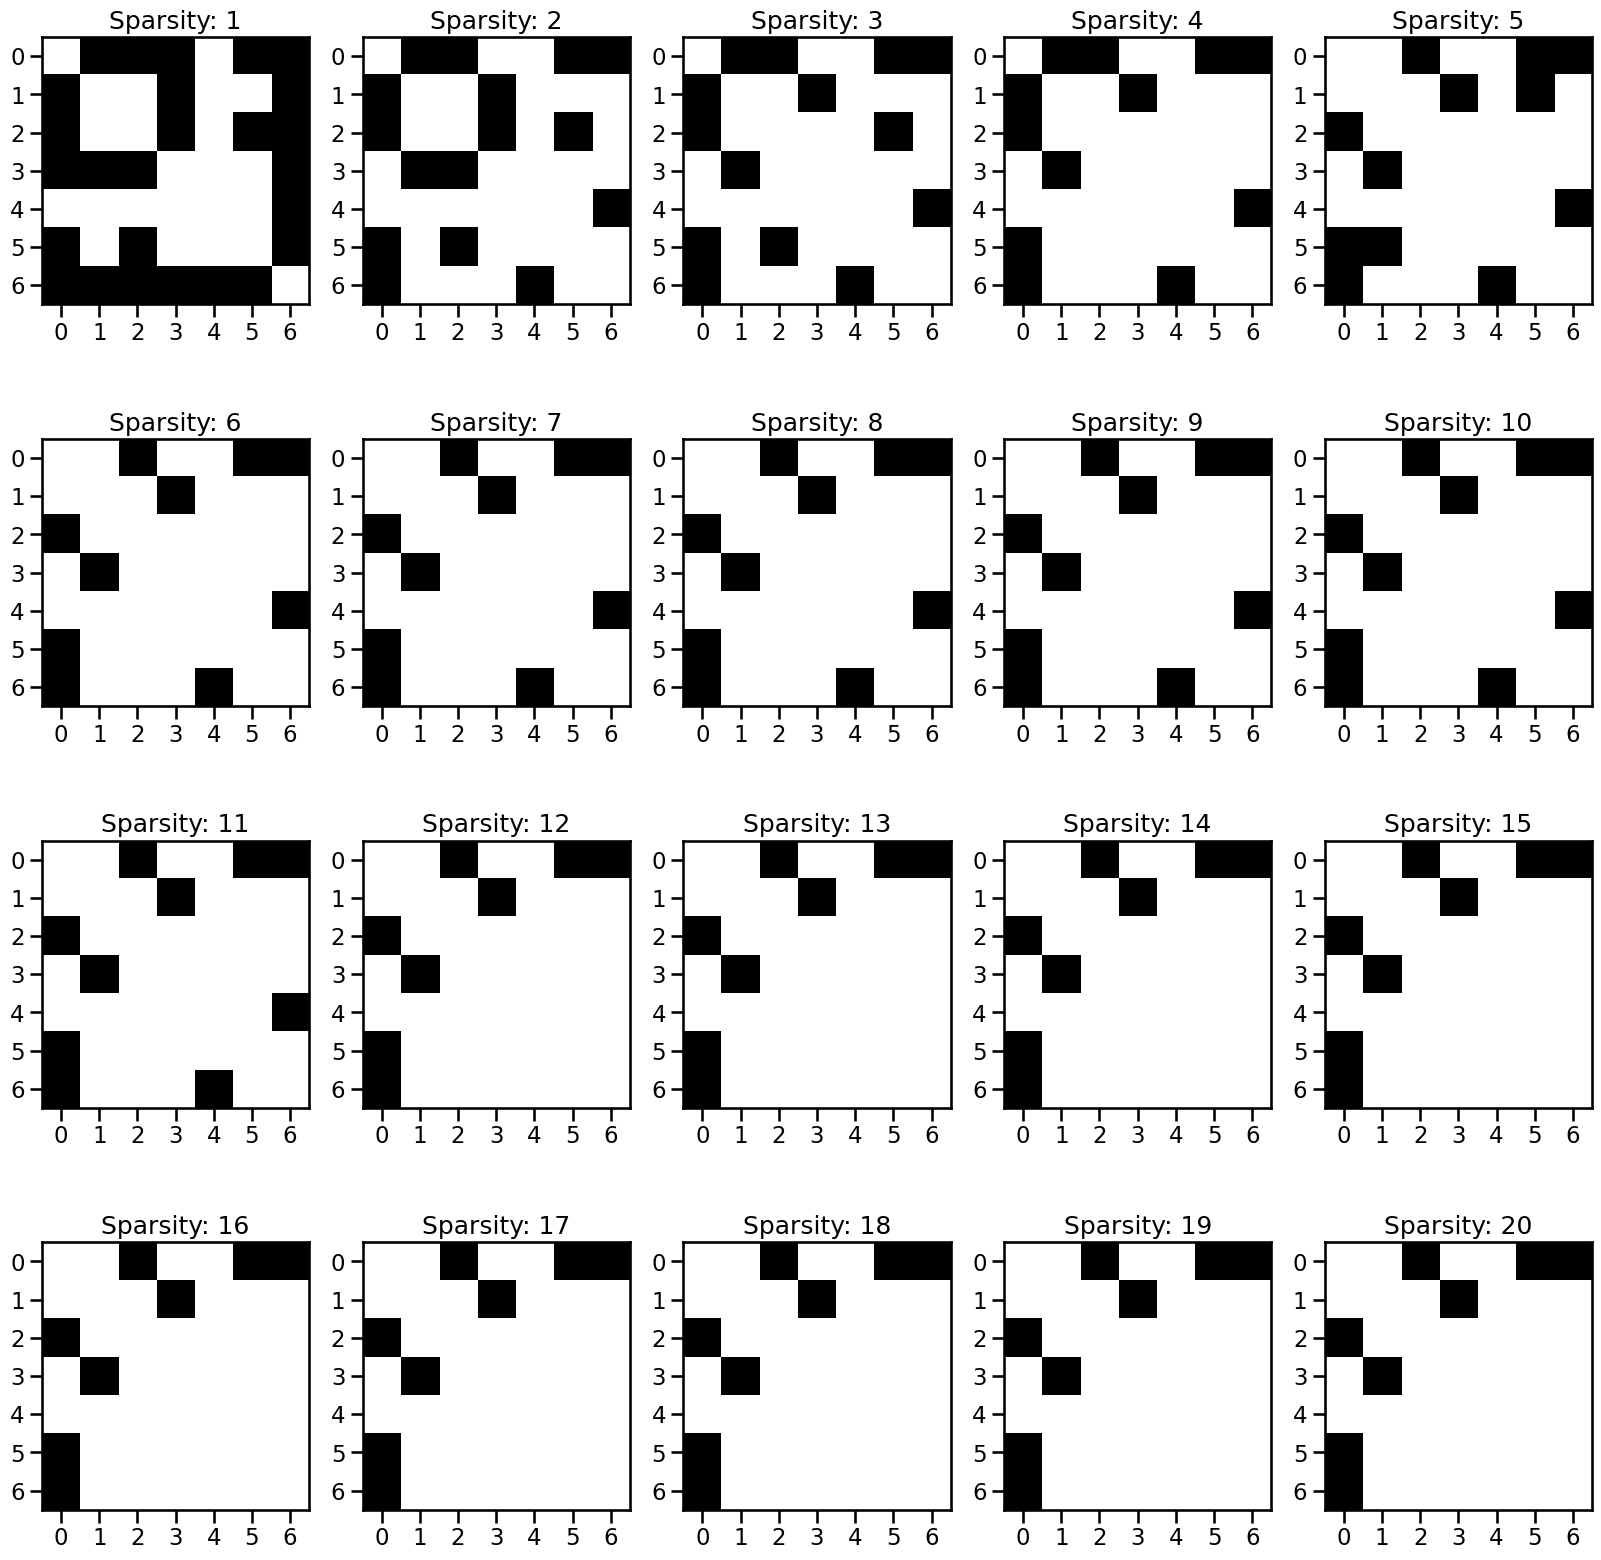

In [ ]:
# TODO: Edit to visualize inferred edge frequencies at varuious sparsities all together to see where range should be / where useless

# visualize adjacency matrices across sparsities
rows = 4
columns = 5

fig,ax = plt.subplots(rows, columns, figsize=(20, 20)) # TODO adjust figsize,

# can prbly improve loop
idx = 0
for i in range(rows):
  for j in range(columns):
    im = ax[i, j].imshow(sparsity_adj_mats[idx], cmap='Greys', vmin=0, vmax=1)
    ax[i, j].set_xticks(np.arange(len(var_names)))
    ax[i, j].set_yticks(np.arange(len(var_names)))
    #ax[i, j].set_xticklabels(var_names, rotation=90, ha='center')
    #ax[i, j].set_yticklabels(var_names)
    title = 'Sparsity: ' + str(idx + 1)
    ax[i, j].set_title(title) #fontsize=15
    #plt.colorbar(im, ax=ax[i, j]);
    idx = idx + 1

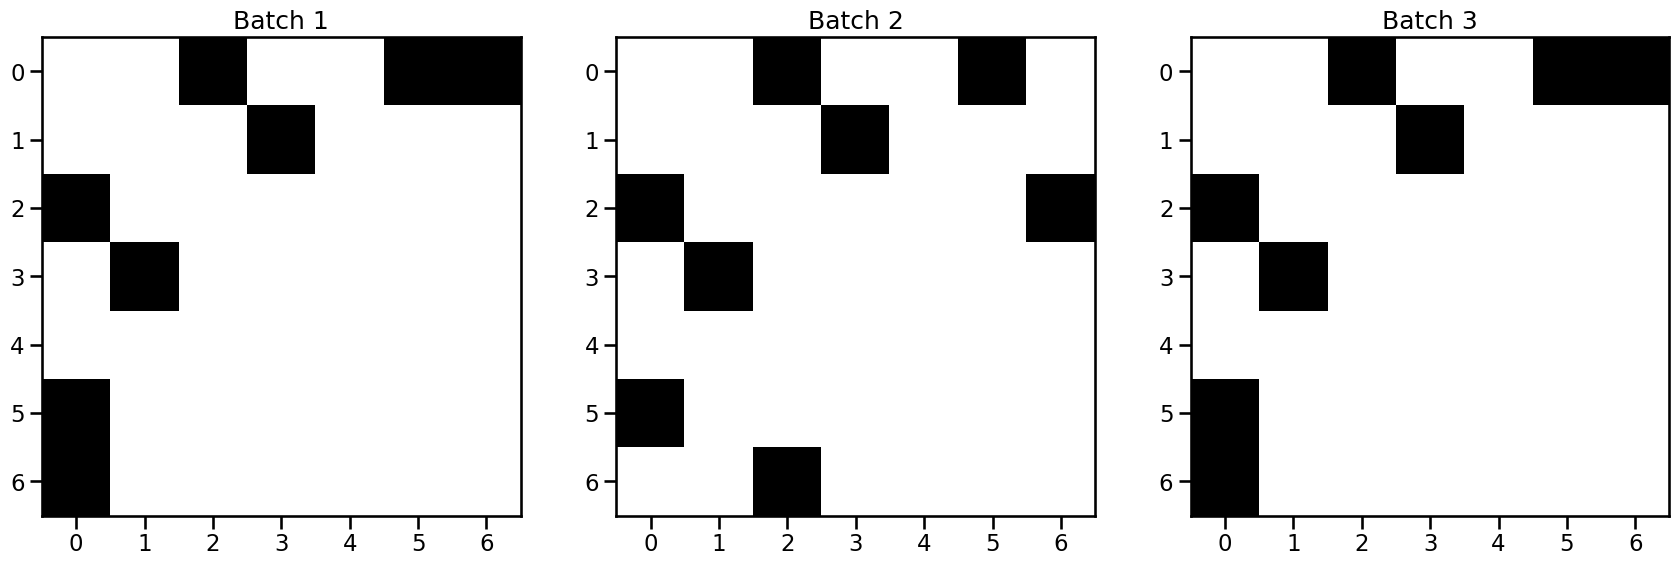

In [ ]:
# TODO: inferred adjacency matrices over batches
rows = 1
columns = 3

fig,ax = plt.subplots(rows, columns, figsize=(21,7))

# can prbly improve loop
for j in range(columns):
  im = ax[j].imshow(batch_adj_mats[j], cmap='Greys', vmin=0, vmax=1)
  ax[j].set_xticks(np.arange(len(var_names)))
  ax[j].set_yticks(np.arange(len(var_names)))
  #ax[j].set_xticklabels(var_names, rotation=90, ha='center')
  #ax[j].set_yticklabels(var_names)
  title = 'Batch ' + str(j + 1)
  ax[j].set_title(title) # , fontsize=15
  #plt.colorbar(im, ax=ax);

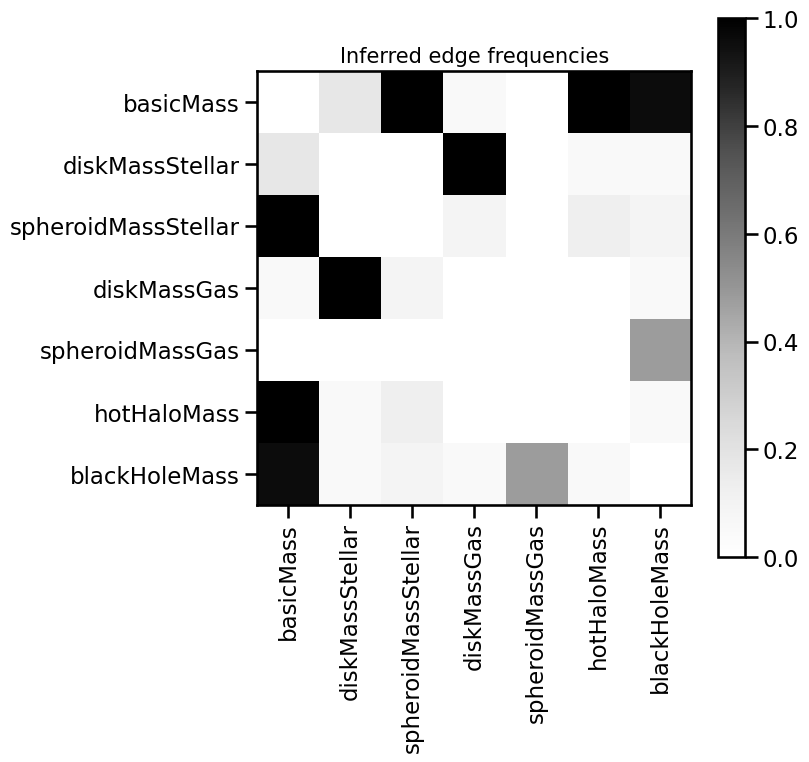

In [ ]:
# compute average adjacency matrix
avg_adj_mat = np.mean(adj_mats, axis=0)

# visualize average adjacency matrix
fig,ax = plt.subplots(figsize=(7,7))
im = ax.imshow(avg_adj_mat, cmap='Greys', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(var_names)))
ax.set_yticks(np.arange(len(var_names)))
ax.set_xticklabels(var_names, rotation=90, ha='center')
ax.set_yticklabels(var_names)
ax.set_title('Inferred edge frequencies', fontsize=15)
plt.colorbar(im, ax=ax);

Link to [summary sheet](https://docs.google.com/document/d/1caYNJi2Ovd1ABpfrmxRv-athhsmS3YvAJNIIOGwTOrA/edit?usp=sharing) to download and annotate


---


For a graphical representation, we can create a NetworkX graph from the edge frequency matrix



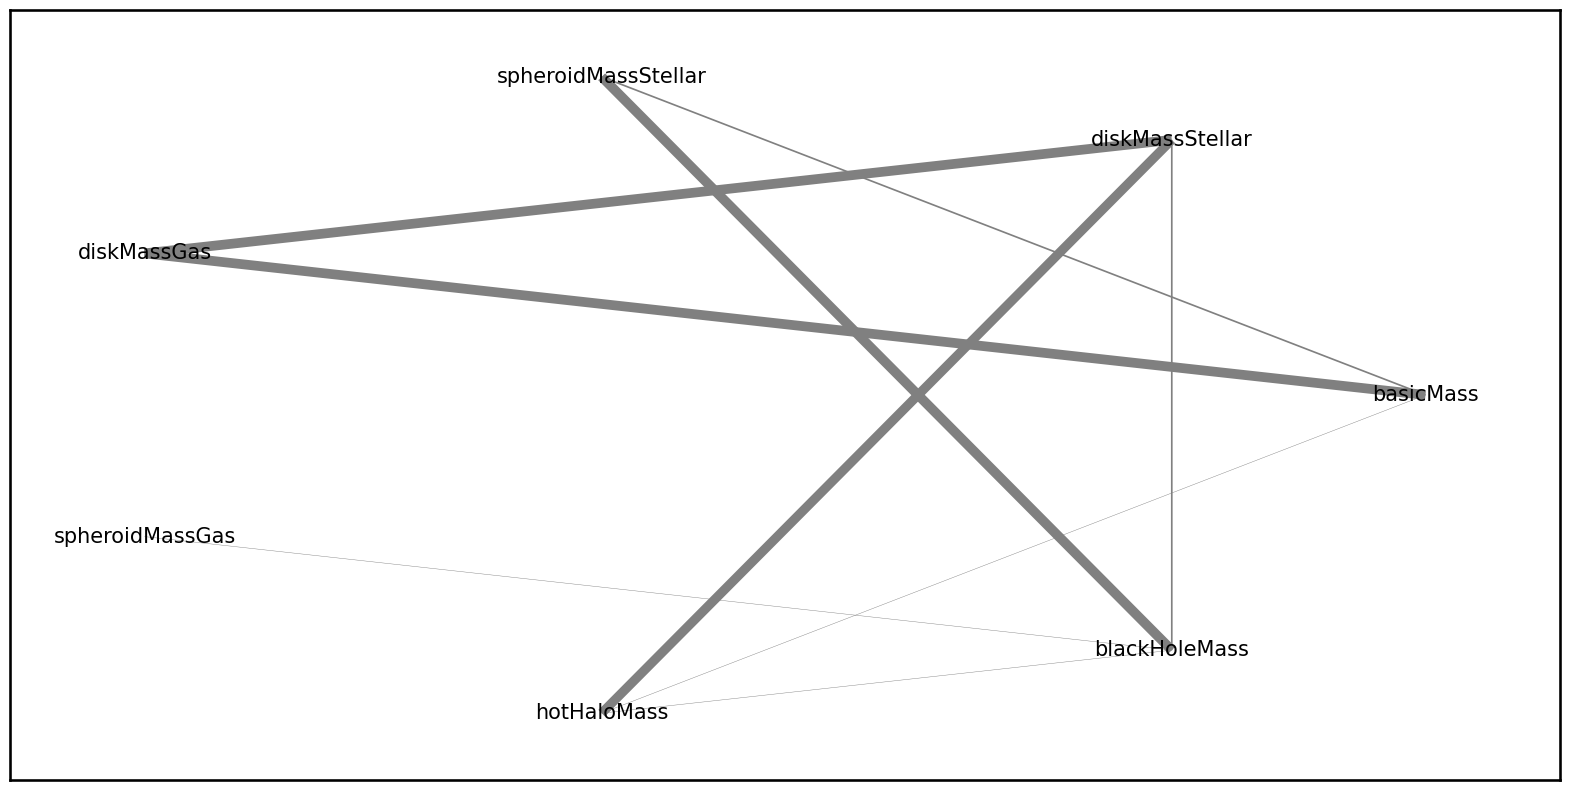

In [ ]:
# TODO: Circle layout, directed edges, bowed edges sometimes
# Undirected graph right now, somewhat messy presentation
import networkx as nx
import matplotlib.pyplot as plt

# Create a NetworkX graph from the average adjacency matrix
graph = nx.from_numpy_array(avg_adj_mat)

# Name nodes
number_to_name = {}
node_count = graph.number_of_nodes()
for node_num in range(node_count):
    number_to_name[node_num] = var_names[node_num]

nx.relabel_nodes(graph, number_to_name, copy=False)

# Set edge width based on frequency
edge_width = [7 * freq for freq in avg_adj_mat.flatten()]

# Create position dictionary for layout
positions = nx.circular_layout(graph)

# Draw the graph with edge width representing frequency: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
fig = plt.figure(1, figsize=(20, 10))
nx.draw_networkx(graph, pos=positions, with_labels=True, edge_color='gray', width=edge_width, node_size=0, font_size=15)
plt.show()